In [1]:
# Load Libraries to import data
import os
import requests, zipfile, io

In [2]:
# this is the current directory where files will get downloaded
os.getcwd()

'/gpfs/global_fs01/sym_shared/YPProdSpark/user/s464-34b6a4b5362a4f-d117115dcabe/notebook/work'

In [3]:
# load data from AWS into platform. We used AWS as IBM currently does not support uploading Images from Local Desktop
url = requests.get('https://s3.us-east-2.amazonaws.com/ids594ml/Archive.zip')
data = zipfile.ZipFile(io.BytesIO(url.content))
data.extractall()

In [4]:
# check if the files have been download in current directory
os.listdir()

['trainml.csv', '__MACOSX', 'test_img', 'train_img', 'test.csv']

In [7]:
# Installing package to read images
! pip install opencv-python

    100% |████████████████████████████████| 15.5MB 82kB/s  eta 0:00:01


In [8]:
# Install package to get status bar while reading data:
! pip install tqdm

    100% |████████████████████████████████| 51kB 7.2MB/s eta 0:00:01


In [1]:
# import libaries
import pandas as pd
import numpy as np
import cv2
import os, sys
from tqdm import tqdm

In [2]:
# load CSV file that has Image ID and corresponding Label
train = pd.read_csv('trainml.csv')
test = pd.read_csv('test.csv')

In [3]:
# function to read image
def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (64, 64))
    return img

In [4]:
## set path for images
TRAIN_PATH = 'train_img/'
TEST_PATH = 'test_img/'

In [5]:
#load images
train_img, test_img = [],[]
for img_path in tqdm(train['image_id'].values):
    train_img.append(read_img(TRAIN_PATH + img_path + '.png'))

for img_path in tqdm(test['image_id'].values):
    test_img.append(read_img(TEST_PATH + img_path + '.png'))

100%|██████████| 965/965 [00:18<00:00, 53.53it/s]


In [6]:
# normalize images
x_train = np.array(train_img, np.float32) / 255.
x_test = np.array(test_img, np.float32) / 255.

In [7]:
# target variable - encoding numeric value
label_list = train['label'].tolist()
Y_train = {k:v for v,k in enumerate(set(label_list))}
y_train = [Y_train[k] for k in label_list]   
y_train = np.array(y_train)

label_list = test['label'].tolist()
Y_test = {k:v for v,k in enumerate(set(label_list))}
y_test = [Y_test[k] for k in label_list]   
y_test = np.array(y_test)

In [8]:
#Import libraries
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
#Transfer learning with Inception V3 
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [15]:
# Model 1
# set model architechture 
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dense(y_train.shape[1], activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-5, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [16]:
#Define function to process the image
batch_size = 10
epochs = 7

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
test_datagen.fit(x_test)

In [ ]:
#Fit the model
history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    #validation_split=0.3,
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    #callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
)

Epoch 1/7
225/225 [==============================] - 398s - loss: 3.2088 - acc: 0.0693   
Epoch 2/7
225/225 [==============================] - 395s - loss: 3.1298 - acc: 0.1009   
Epoch 3/7
225/225 [==============================] - 402s - loss: 3.0798 - acc: 0.1191   
Epoch 4/7
225/225 [==============================] - 399s - loss: 3.0292 - acc: 0.1316   
Epoch 5/7
225/225 [==============================] - 399s - loss: 2.9675 - acc: 0.1609   
Epoch 6/7
225/225 [==============================] - 397s - loss: 2.8998 - acc: 0.1689   
Epoch 7/7
225/225 [==============================] - 396s - loss: 2.8053 - acc: 0.2013   


In [ ]:
#Model Accuracy and Loss
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.743012747
Test accuracy: 0.19585492228


In [11]:
# Model 2
# set model architechture 
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(64, activation='relu'))
add_model.add(Dense(y_train.shape[1], activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.7),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [12]:
# Fit the model
history=model.fit(x_train, y_train, batch_size=10, epochs=7, validation_split=0.3)

Train on 1575 samples, validate on 675 samples
Epoch 1/7
1575/1575 [==============================] - 297s - loss: 3.2885 - acc: 0.0438 - val_loss: 3.1461 - val_acc: 0.1022
Epoch 2/7
1575/1575 [==============================] - 295s - loss: 3.0978 - acc: 0.1111 - val_loss: 3.0295 - val_acc: 0.1467
Epoch 3/7
1575/1575 [==============================] - 294s - loss: 2.9137 - acc: 0.1689 - val_loss: 2.8581 - val_acc: 0.1970
Epoch 4/7
1575/1575 [==============================] - 307s - loss: 2.6404 - acc: 0.2514 - val_loss: 2.5831 - val_acc: 0.2637
Epoch 5/7
1575/1575 [==============================] - 308s - loss: 2.3323 - acc: 0.3257 - val_loss: 2.4036 - val_acc: 0.3037
Epoch 6/7
1575/1575 [==============================] - 297s - loss: 2.0607 - acc: 0.3822 - val_loss: 2.3461 - val_acc: 0.3333
Epoch 7/7
1575/1575 [==============================] - 296s - loss: 1.7803 - acc: 0.4514 - val_loss: 2.3482 - val_acc: 0.3674


In [13]:
# Model accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.45579949587
Test accuracy: 0.328497409342


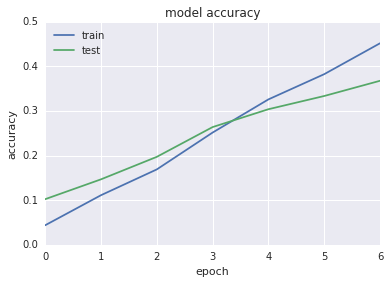

In [14]:
# summarize history for accuracy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

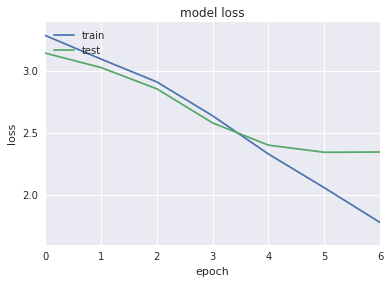

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# Model 3 - Best Model

# set model architechture 
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(y_train.shape[1], activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-5, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [12]:
# Fitting the model
history=model.fit(x_train, y_train, batch_size=10, epochs=15, validation_split=0.3)

Train on 1575 samples, validate on 675 samples
Epoch 1/15
1575/1575 [==============================] - 306s - loss: 3.3538 - acc: 0.0559 - val_loss: 3.2307 - val_acc: 0.0593
Epoch 2/15
1575/1575 [==============================] - 301s - loss: 3.2071 - acc: 0.0692 - val_loss: 3.1502 - val_acc: 0.0933
Epoch 3/15
1575/1575 [==============================] - 302s - loss: 3.1315 - acc: 0.0984 - val_loss: 3.1001 - val_acc: 0.0993
Epoch 4/15
1575/1575 [==============================] - 292s - loss: 3.0754 - acc: 0.1213 - val_loss: 3.0572 - val_acc: 0.1244
Epoch 5/15
1575/1575 [==============================] - 298s - loss: 3.0224 - acc: 0.1441 - val_loss: 3.0160 - val_acc: 0.1452
Epoch 6/15
1575/1575 [==============================] - 295s - loss: 2.9693 - acc: 0.1594 - val_loss: 2.9730 - val_acc: 0.1600
Epoch 7/15
1575/1575 [==============================] - 300s - loss: 2.9087 - acc: 0.1873 - val_loss: 2.9228 - val_acc: 0.1763
Epoch 8/15
1575/1575 [==============================] - 294s - l

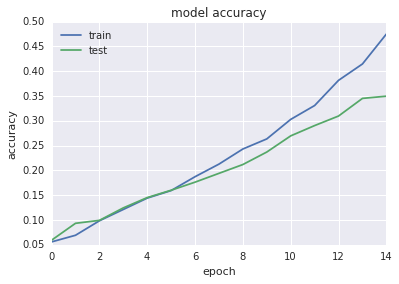

In [13]:
# summarize history for accuracy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

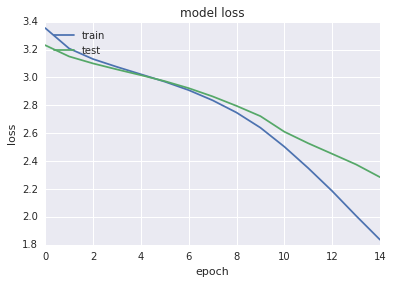

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()